In [1]:
%load_ext autoreload
%autoreload 2

import os
from jax import config
config.update("jax_enable_x64", True)

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
from encoding_information.gpu_utils import limit_gpu_memory_growth
limit_gpu_memory_growth()

from encoding_information.datasets import BSCCMDataset, MNISTDataset, ColorFilterArrayDataset
import jax.numpy as np
import numpy as onp

from cleanplots import *

def plot_filter(array):
    """
    Plots a 2D array with values 0, 1, 2, 3 as an image with thin black borders outlining each pixel.
    0 -> Red, 1 -> Green, 2 -> Blue, 3 -> White
    """
    fig, ax = plt.subplots(figsize=(3, 3))

    # Map values 0, 1, 2, 3 to RGB colors
    color_map = {
        0: [1, 0, 0],  # Red
        1: [0, 1, 0],  # Green
        2: [0, 0, 1],  # Blue
        3: [1, 1, 1]   # White
    }

    # Create an RGB image
    image = np.zeros((array.shape[0], array.shape[1], 3))
    for i in range(array.shape[0]):
        for j in range(array.shape[1]):
            image[i, j] = color_map[array[i, j]]

    # Plot the image
    ax.imshow(image, origin='upper')

    # Draw thin black borders
    for i in range(array.shape[0] + 1):
        ax.axhline(i - 0.5, color='black', linewidth=1)  # Horizontal lines
    for j in range(array.shape[1] + 1):
        ax.axvline(j - 0.5, color='black', linewidth=1)  # Vertical lines

    # Remove axis ticks for a cleaner image
    ax.set_xticks([])
    ax.set_yticks([])


2024-09-20 11:16:34.584177: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-20 11:16:35.682153: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-09-20 11:16:35.682257: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-09-20 11:16:35.682268: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


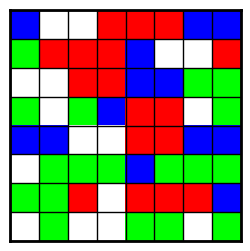

In [2]:

# filter = [[0, 1], [1, 2]]  # Bayer pattern
onp.random.seed(1253)
filter = onp.random.randint(0, 4, (8, 8))  # Random pattern
# filter = np.array([[3,1,3,3,0,3,3,3],  # The end-to-end learned filter
#                     [0,3,3,3,3,3,0,3],
#                     [1,3,2,2,3,2,3,3],
#                     [0,2,3,3,1,3,1,2],
#                     [3,3,3,3,3,1,0,3],
#                     [3,0,3,1,3,3,1,0],
#                     [0,3,2,3,1,3,3,3],
#                     [3,1,3,3,3,3,2,2]])

plot_filter(filter)

plt.gcf().savefig('/home/hpinkard_waller/figures/random_color_filter

In [3]:
from encoding_information import extract_patches

patch_size = 16
num_patches = 2000
test_set_size = 200
data_seed = 1258983

dataset = ColorFilterArrayDataset('/home/hpinkard_waller/data/four_channel_images.zarr', tile_size=128)

measurements = dataset.get_measurements(num_measurements=num_patches + test_set_size, filter_matrix=filter, noise=None, data_seed=data_seed)

patches = extract_patches(measurements[:-test_set_size], patch_size=patch_size, num_patches=num_patches, strategy='cropped', crop_location=(0, 0), verbose=True)
test_patches = extract_patches(measurements[-test_set_size:], patch_size=patch_size, num_patches=test_set_size, strategy='cropped', crop_location=(0, 0), verbose=True)                          

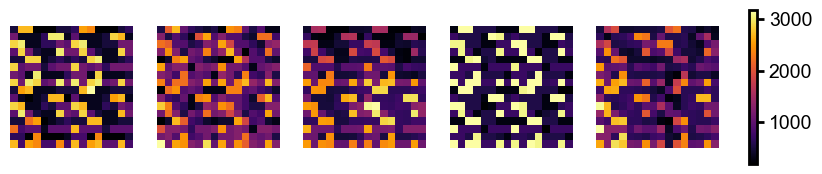

In [4]:
vmin, vmax = None, None

fig, ax = plt.subplots(1, 5, figsize=(10, 2))
for i in range(5):
    im = ax[i].imshow(patches[i], cmap='inferno', vmin=vmin, vmax=vmax)
    ax[i].axis('off')
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

In [6]:
# train full Gaussian and pixelCNN models
from encoding_information.models import PixelCNN, FullGaussianProcess

num_samples = 8

full_gp = FullGaussianProcess(patches)

pixel_cnn = PixelCNN()
pixel_cnn_val_loss = pixel_cnn.fit(patches, verbose=False, patience=1000, max_epochs=230)

pixel_cnn_positional_embedding = PixelCNN()
pixel_cnn_pos_embed_loss = pixel_cnn_positional_embedding.fit(patches, use_positional_embedding=True, verbose=False, patience=1000, max_epochs=230)

# generate samples
pixel_cnn_samples = pixel_cnn.generate_samples(num_samples=num_samples)
pixel_cnn_positional_embedding_samples = pixel_cnn_positional_embedding.generate_samples(num_samples=num_samples)
full_gp_samples = full_gp.generate_samples(num_samples=num_samples)

Generating PixelCNN samples:   0%|          | 0/16 [00:00<?, ?it/s]2024-09-18 14:00:15.128780: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:808] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.
2024-09-18 14:00:15.128824: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:811] Conv: (f64[8,128,16,16]{3,2,1,0}, u8[0]{0}) custom-call(f64[8,64,16,16]{3,2,1,0}, f64[128,64,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}
Generating PixelCNN samples: 100%|██████████| 16/16 [01:19<00:00,  4.94s/it]


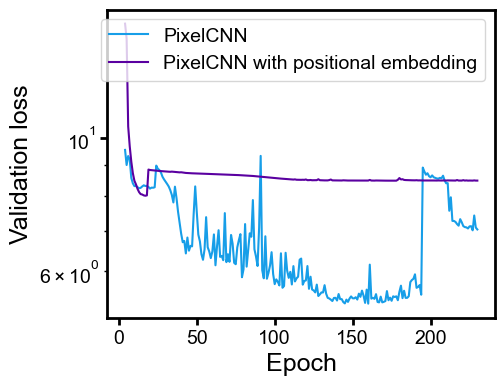

In [7]:
start_index = 4
# plot loss history for two models
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

ax.semilogy(np.arange(len(pixel_cnn_val_loss))[start_index:], pixel_cnn_val_loss[start_index:], label='PixelCNN')
ax.semilogy(np.arange(len(pixel_cnn_pos_embed_loss))[start_index:], pixel_cnn_pos_embed_loss[start_index:], label='PixelCNN with positional embedding')
ax.set_xlabel('Epoch')
ax.set_ylabel('Validation loss')
ax.legend()

In [8]:
from encoding_information.models import PoissonNoiseModel
from encoding_information import estimate_information

noise_model = PoissonNoiseModel()

pixel_cnn_info, pixel_cnn_lower_bound, pixel_cnn_upper_bound = estimate_information(pixel_cnn, noise_model, patches, test_patches, confidence_interval=0.9)
pixel_cnn_positional_embedding_info, pixel_cnn_positional_embedding_lower_bound, pixel_cnn_positional_embedding_upper_bound = estimate_information(
    pixel_cnn_positional_embedding, noise_model, patches, test_patches, confidence_interval=0.9)
full_gp_info, full_gp_lower_bound, full_gp_upper_bound = estimate_information(full_gp, noise_model, patches, test_patches, confidence_interval=0.9)

Evaluating NLL: 7it [00:03,  2.21it/s]
Evaluating NLL: 200it [00:02, 90.21it/s] 
Bootstrapping to compute confidence interval: 100%|██████████| 100/100 [00:00<00:00, 134.07it/s]
Evaluating NLL: 7it [00:01,  4.01it/s]
Evaluating NLL: 200it [00:01, 175.48it/s]
Bootstrapping to compute confidence interval: 100%|██████████| 100/100 [00:01<00:00, 90.25it/s]


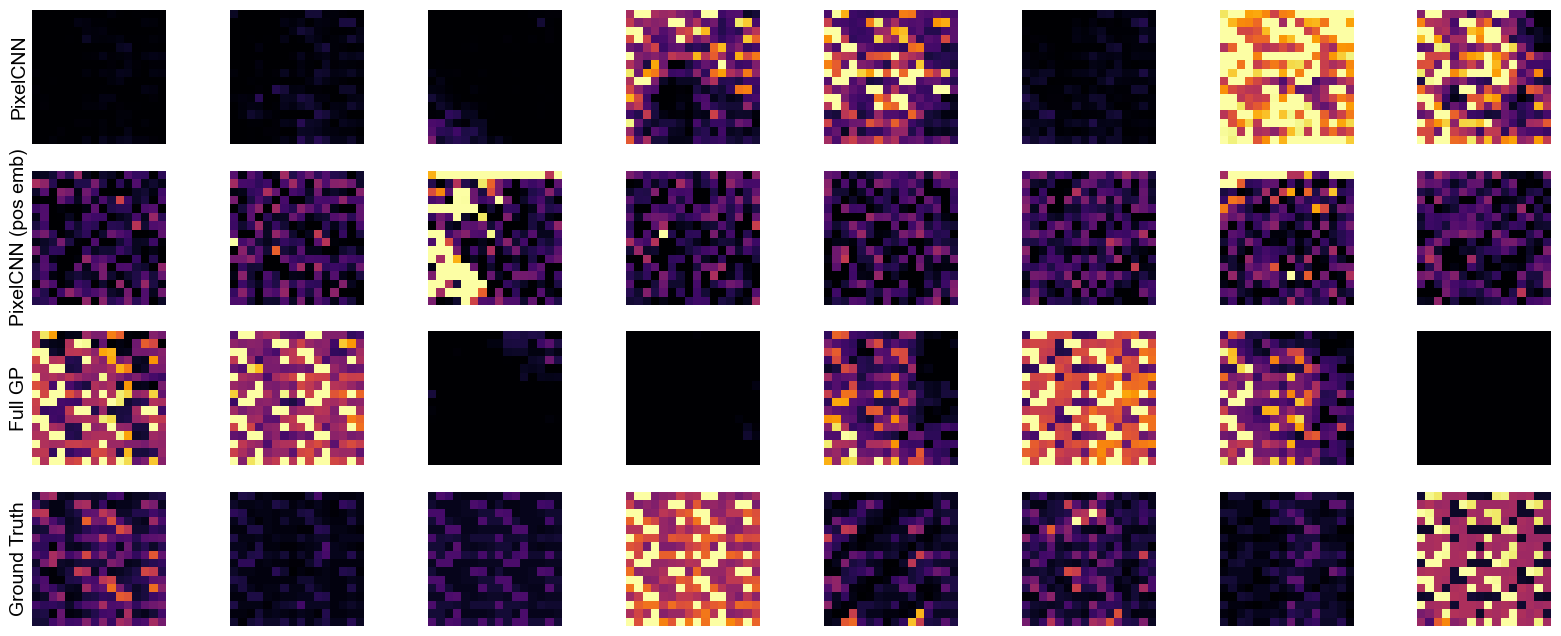

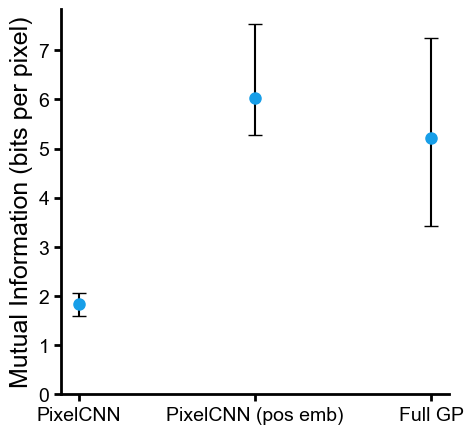

In [9]:
from encoding_information.plot_utils import plot_samples

plot_samples([pixel_cnn_samples, pixel_cnn_positional_embedding_samples, full_gp_samples], test_patches, model_names=['PixelCNN', 'PixelCNN (pos emb)', 'Full GP'], contrast_cutoff=95)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

info = [pixel_cnn_info, pixel_cnn_positional_embedding_info, full_gp_info]
lower_bounds = [pixel_cnn_lower_bound, pixel_cnn_positional_embedding_lower_bound, full_gp_lower_bound]
upper_bounds = [pixel_cnn_upper_bound, pixel_cnn_positional_embedding_upper_bound, full_gp_upper_bound]
lower_errors = np.abs(np.array(info) - np.array(lower_bounds))
upper_errors = np.abs(np.array(upper_bounds) - np.array(info))
error_bars = [lower_errors, upper_errors]

plt.errorbar([0, 1, 2], [pixel_cnn_info, pixel_cnn_positional_embedding_info, full_gp_info], yerr=error_bars, fmt='o', capsize=5, ecolor='black', markersize=8)
plt.ylabel('Information')
ax.set(ylabel='Mutual Information (bits per pixel)', xticks=[0, 1, 2], xticklabels=['PixelCNN', 'PixelCNN (pos emb)', 'Full GP'], ylim=[0, None])
clear_spines(ax)

# Compare filters
Train E2E filter, random filter, bayer filter with and without pos embedding

Generating PixelCNN samples: 100%|██████████| 16/16 [00:52<00:00,  3.27s/it]
Evaluating NLL: 7it [00:01,  4.70it/s]
Evaluating NLL: 200it [00:01, 191.90it/s]
Bootstrapping to compute confidence interval: 100%|██████████| 100/100 [00:00<00:00, 203.57it/s]
Evaluating NLL: 7it [00:01,  4.36it/s]
Evaluating NLL: 200it [00:01, 193.54it/s]
Generating PixelCNN samples: 100%|██████████| 16/16 [01:00<00:00,  3.81s/it]
Evaluating NLL: 7it [00:01,  4.69it/s]
Evaluating NLL: 200it [00:01, 189.30it/s]
Bootstrapping to compute confidence interval: 100%|██████████| 100/100 [00:00<00:00, 190.90it/s]
Evaluating NLL: 7it [00:01,  4.18it/s]
Evaluating NLL: 200it [00:01, 185.08it/s]
Generating PixelCNN samples: 100%|██████████| 16/16 [01:01<00:00,  3.82s/it]
Evaluating NLL: 7it [00:01,  4.30it/s]
Evaluating NLL: 200it [00:01, 185.89it/s]
Bootstrapping to compute confidence interval: 100%|██████████| 100/100 [00:00<00:00, 157.69it/s]
Evaluating NLL: 7it [00:01,  4.27it/s]
Evaluating NLL: 200it [00:01, 165.

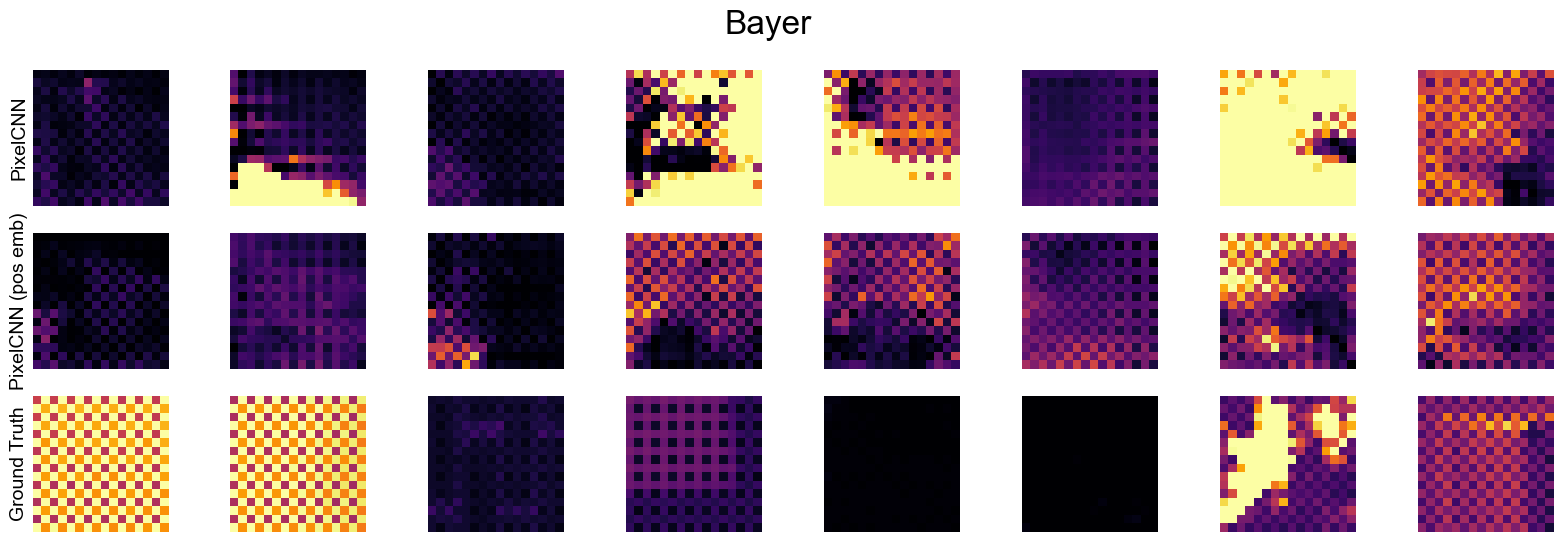

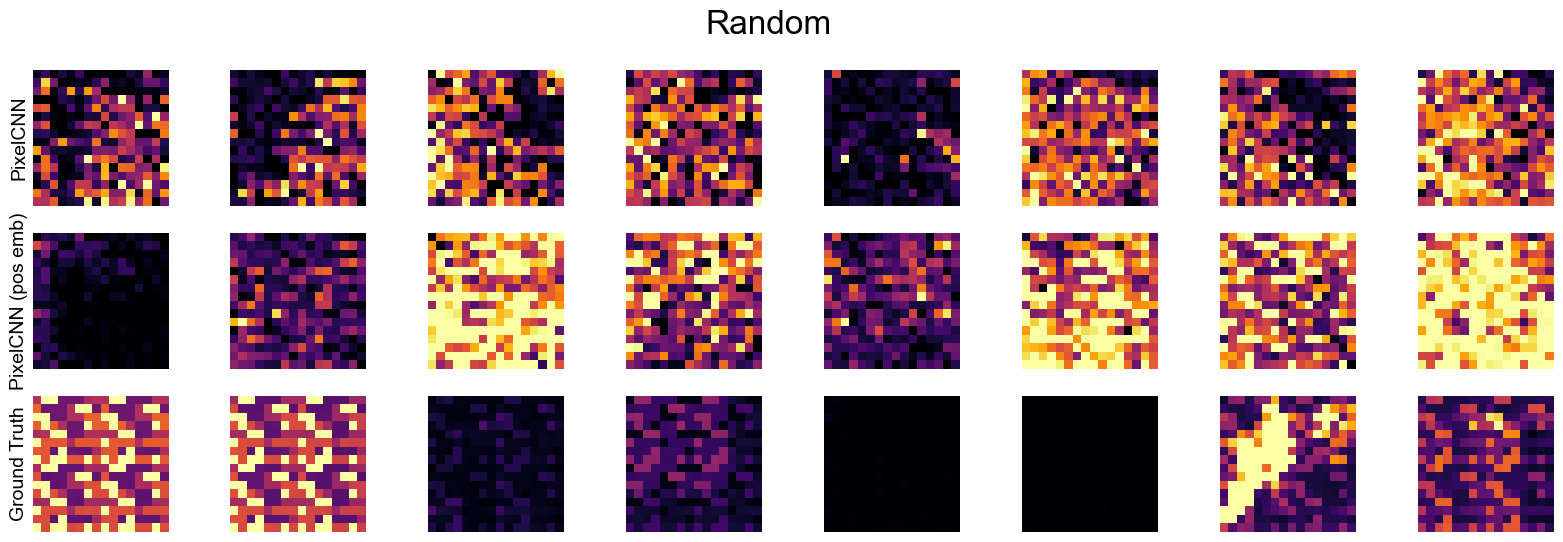

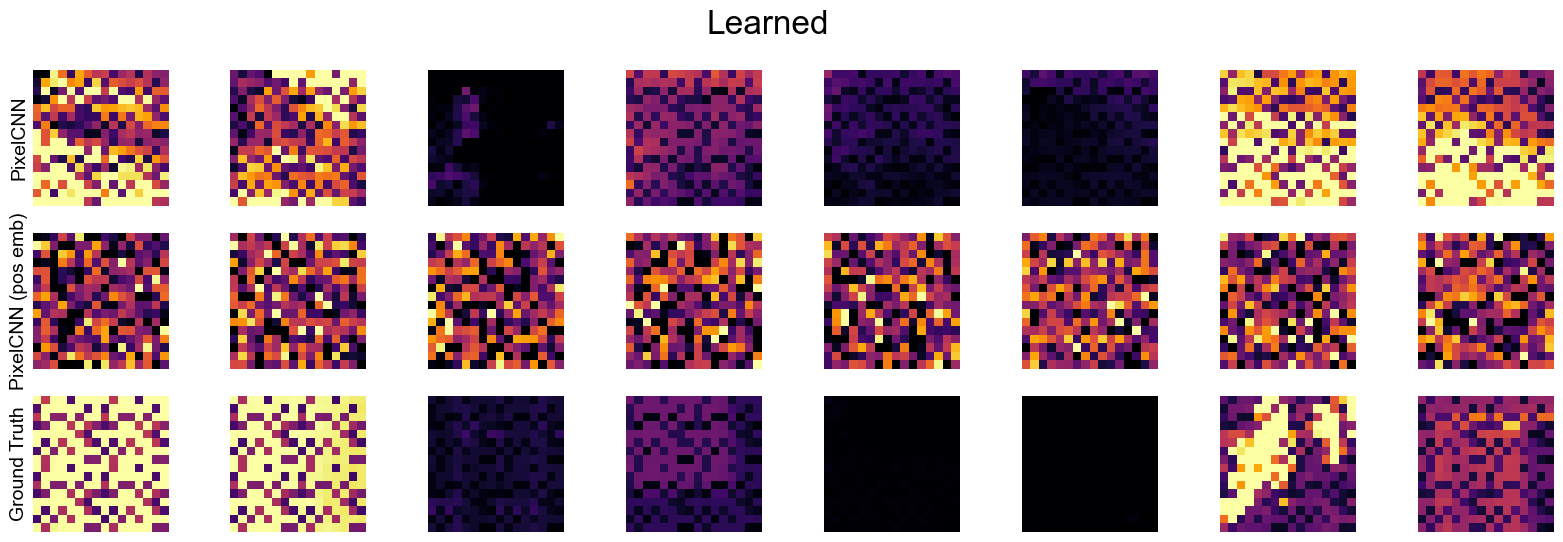

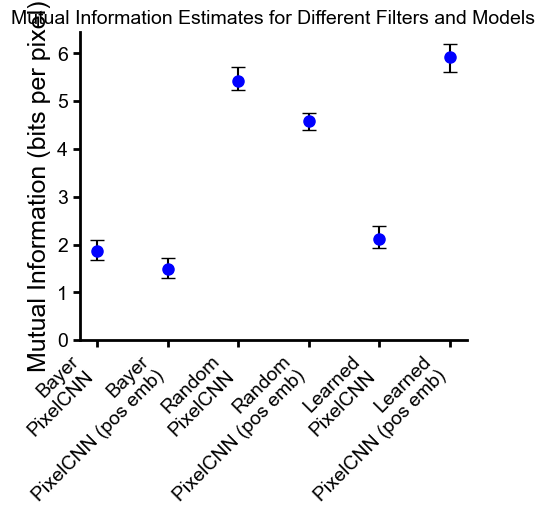

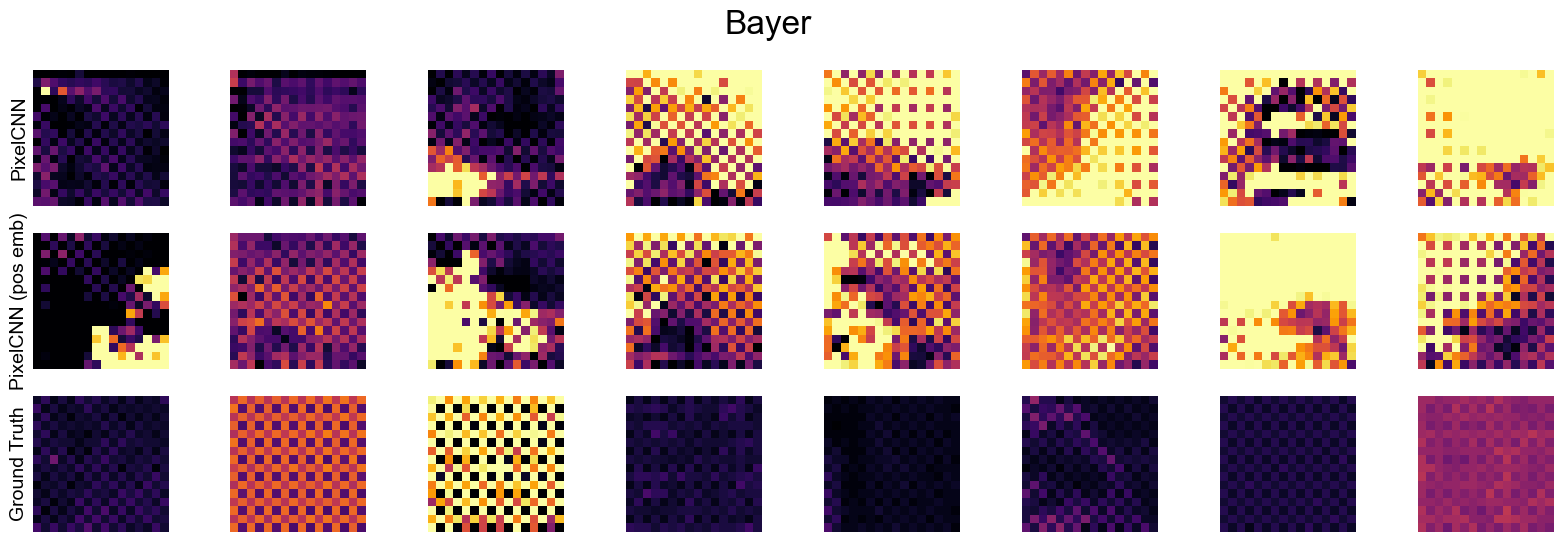

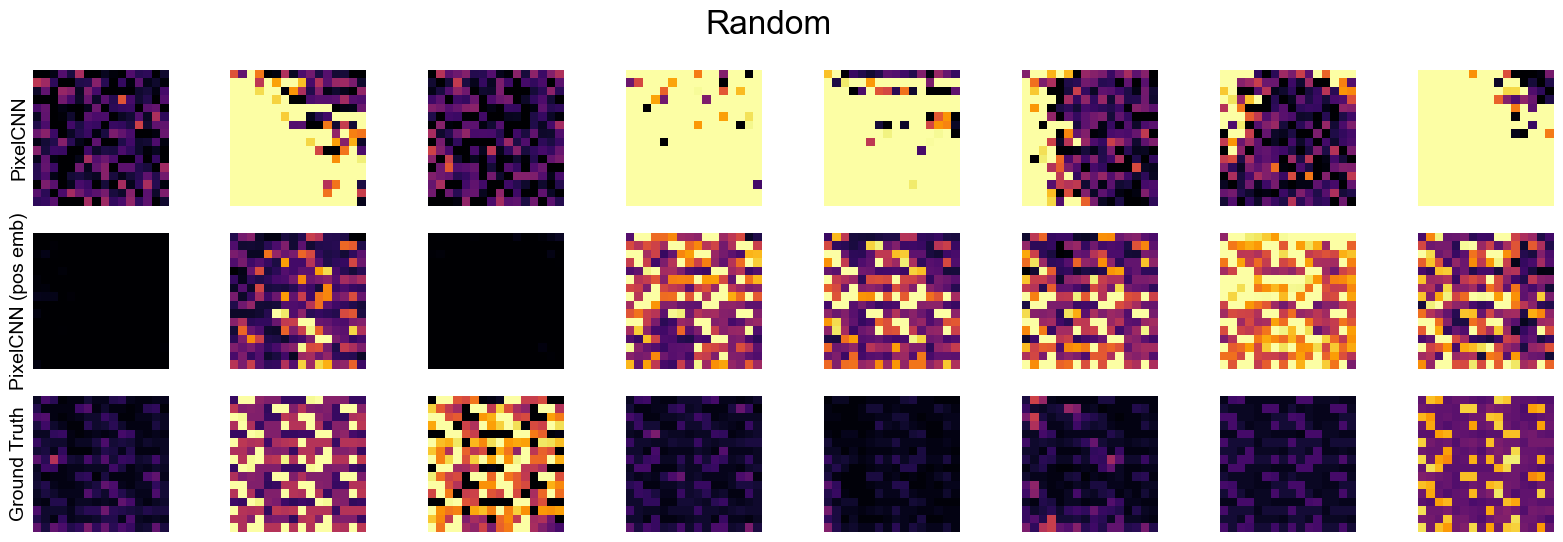

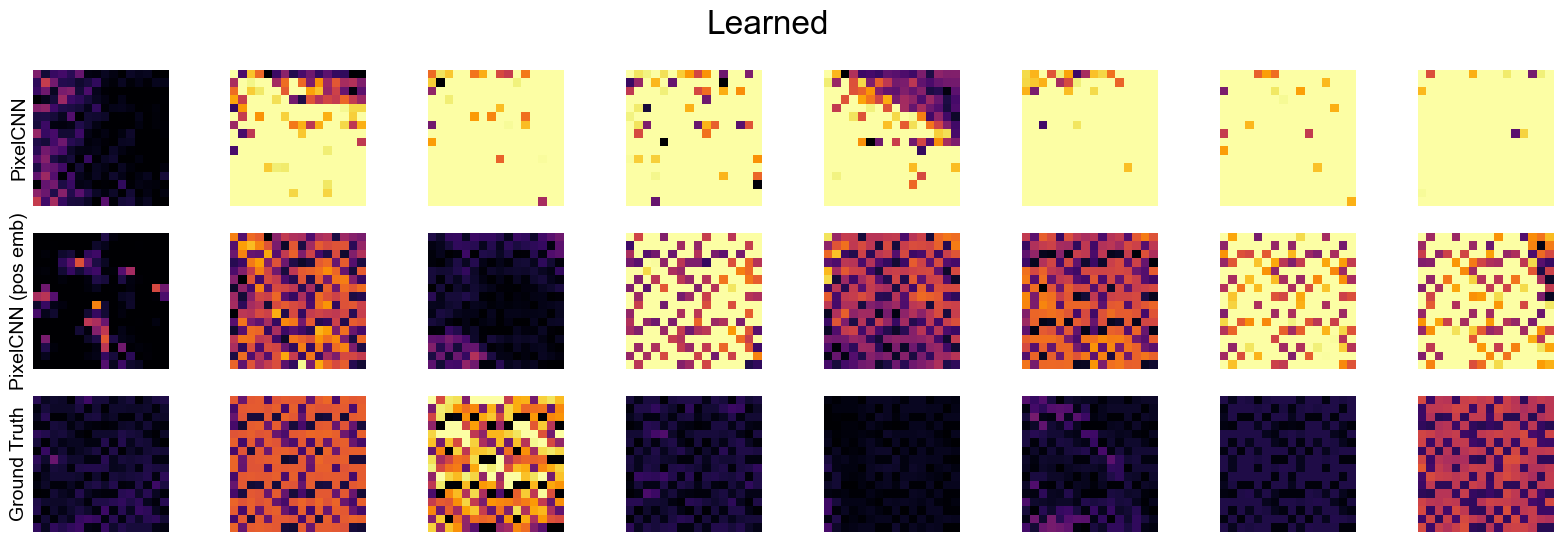

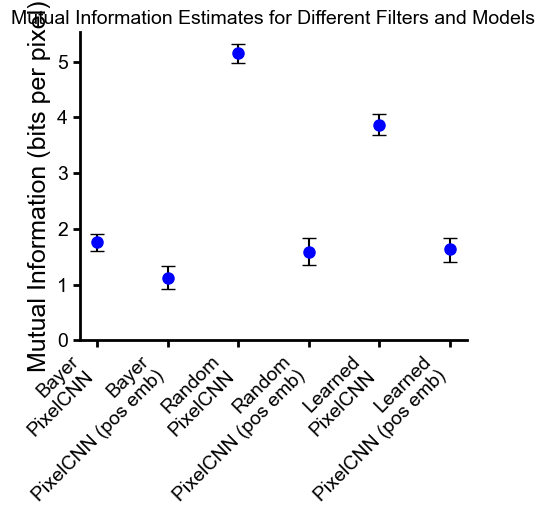

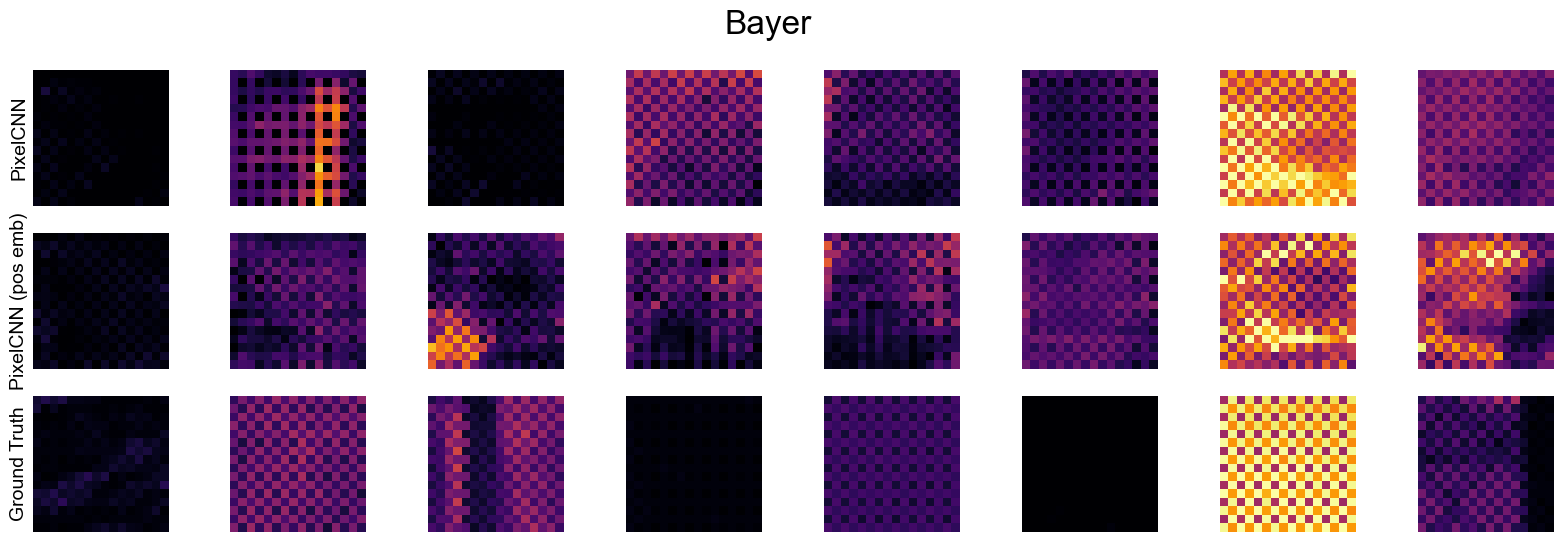

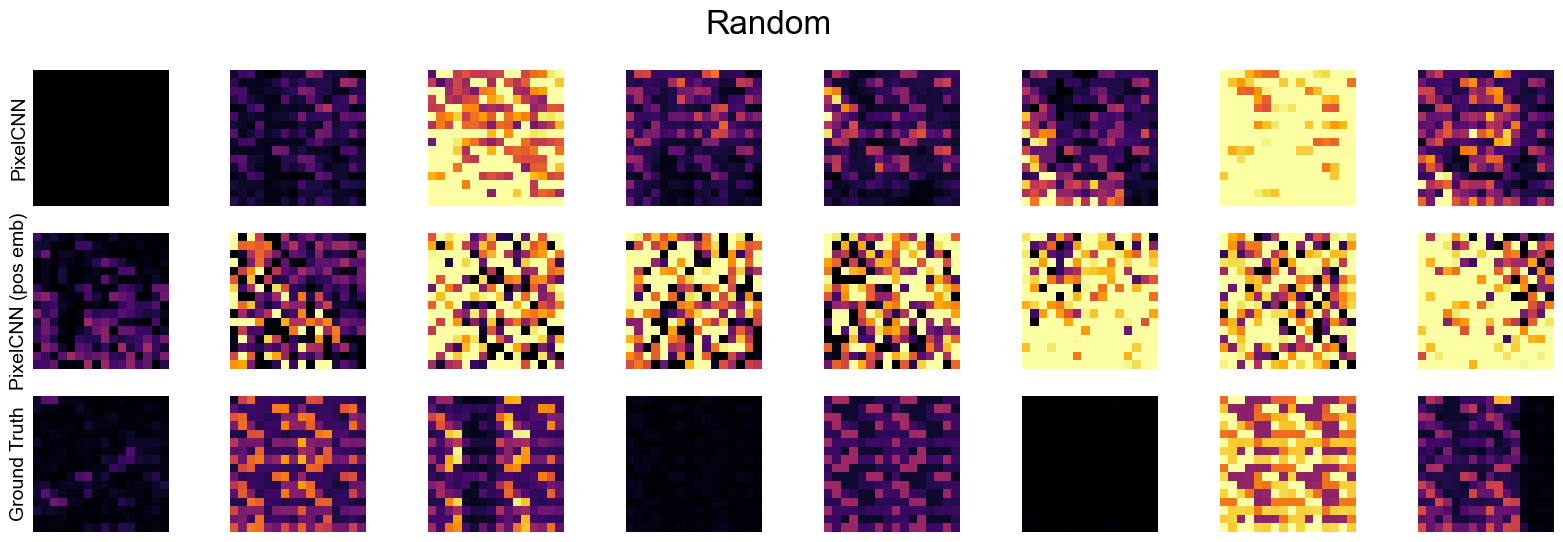

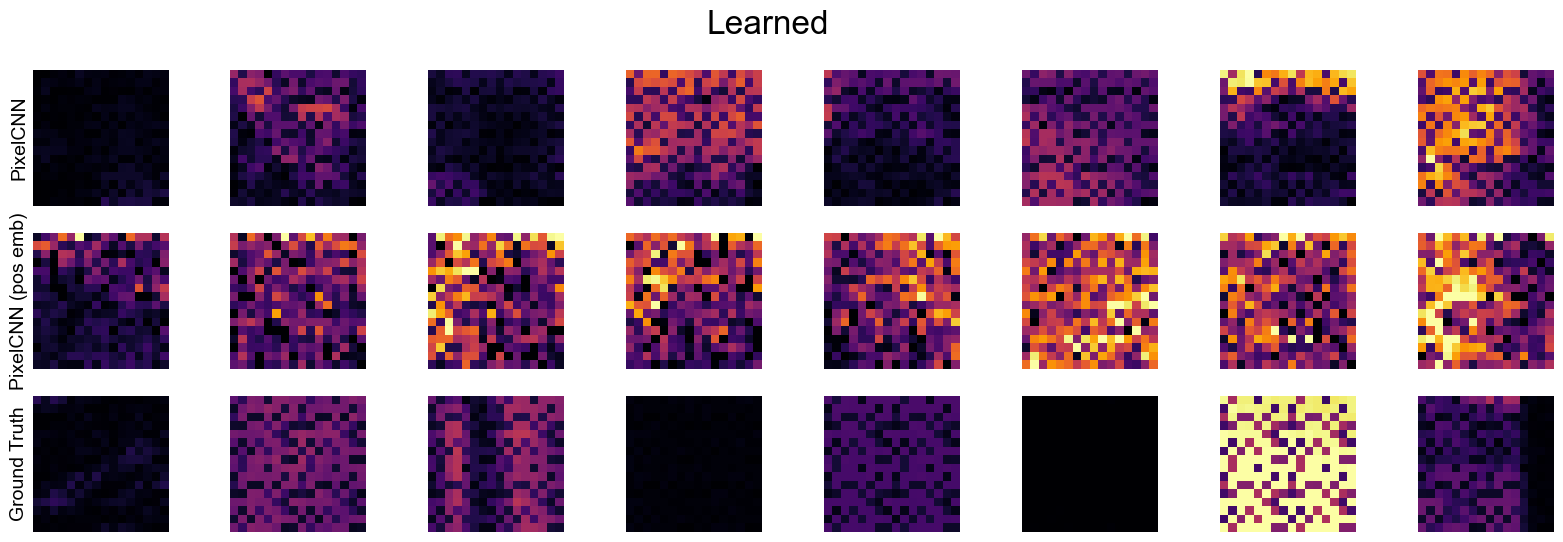

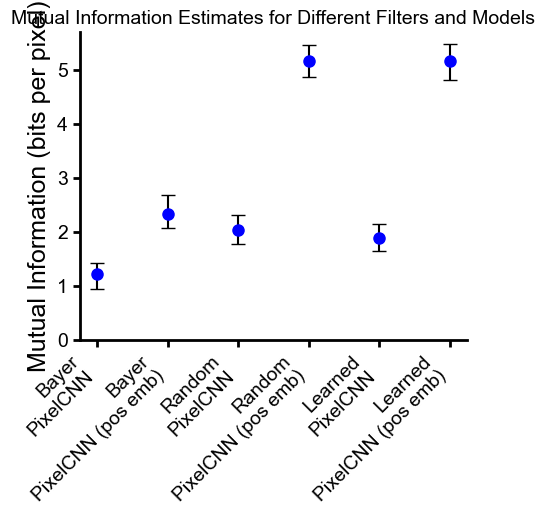

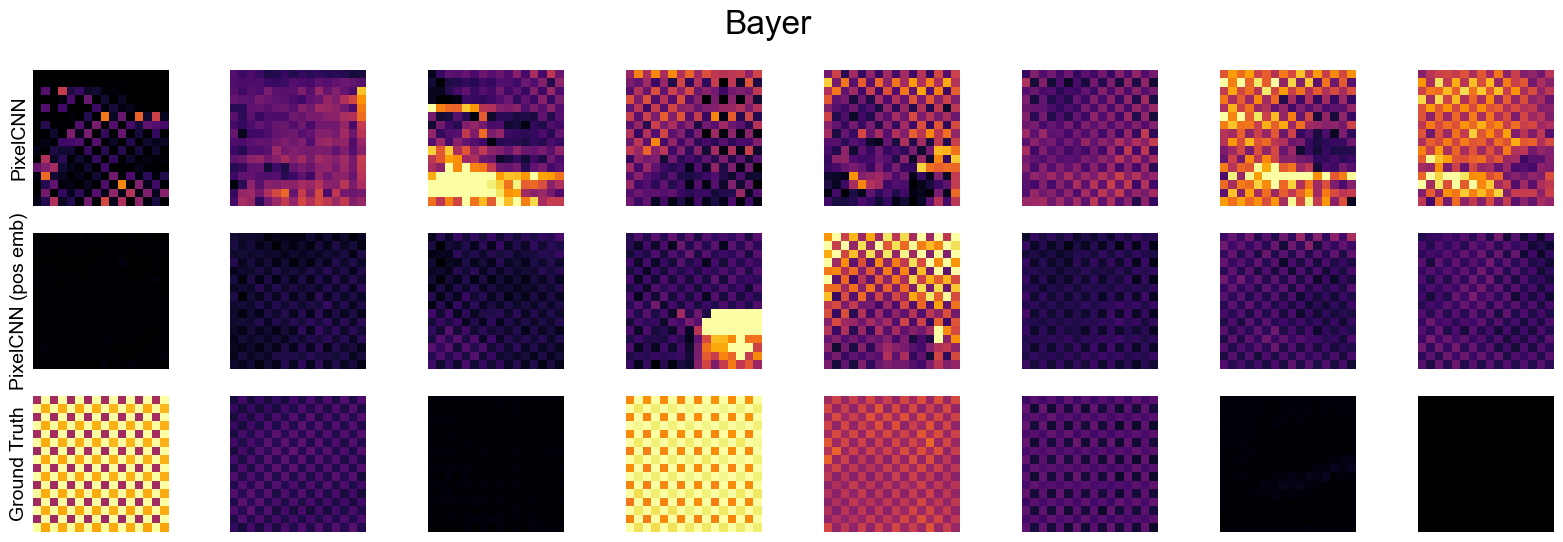

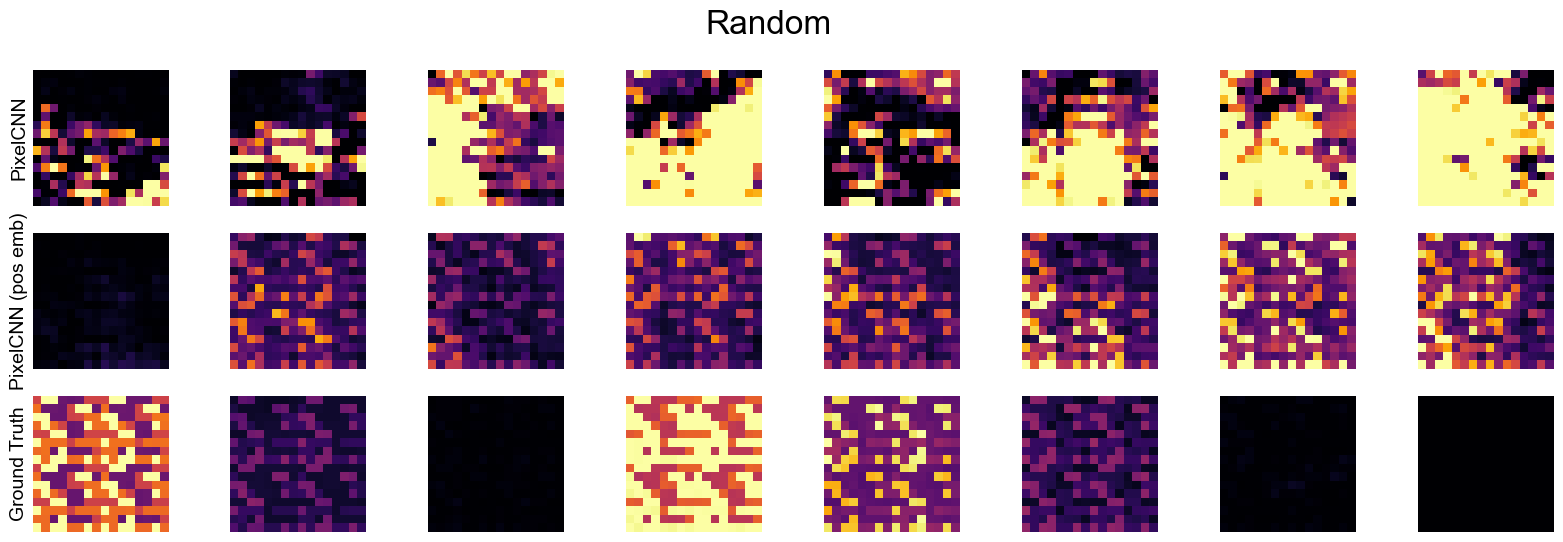

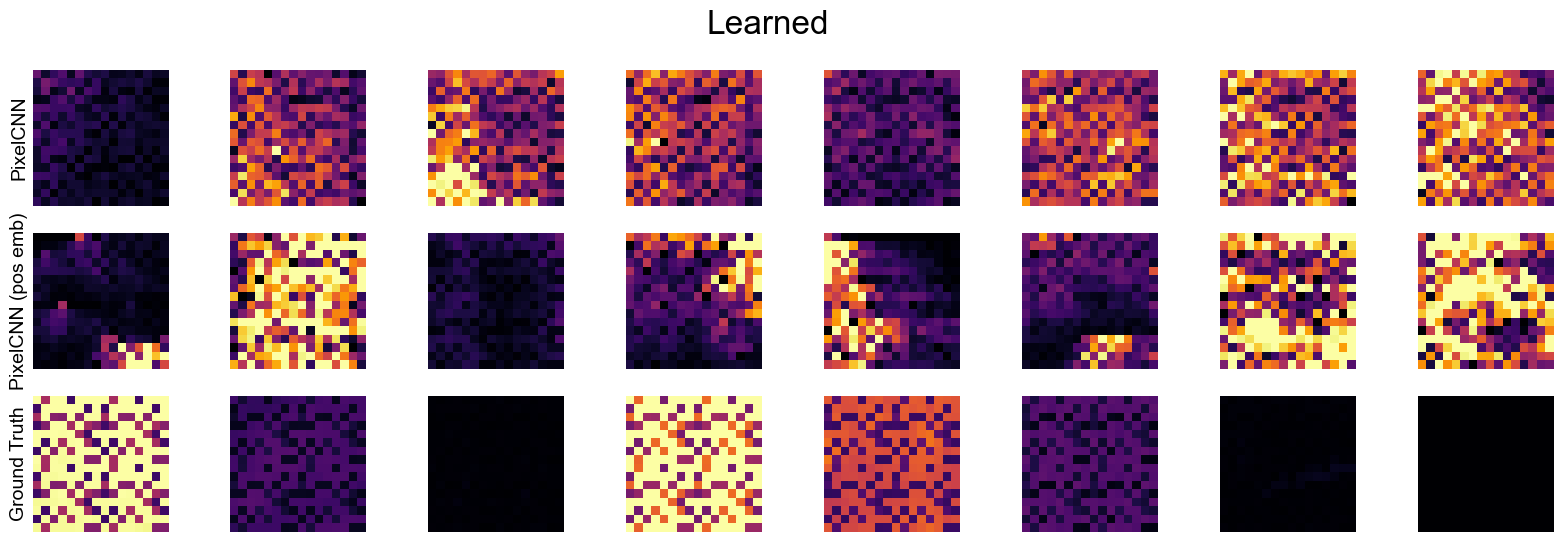

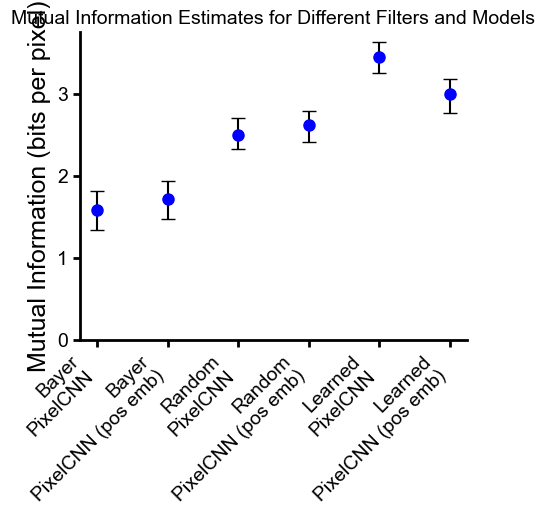

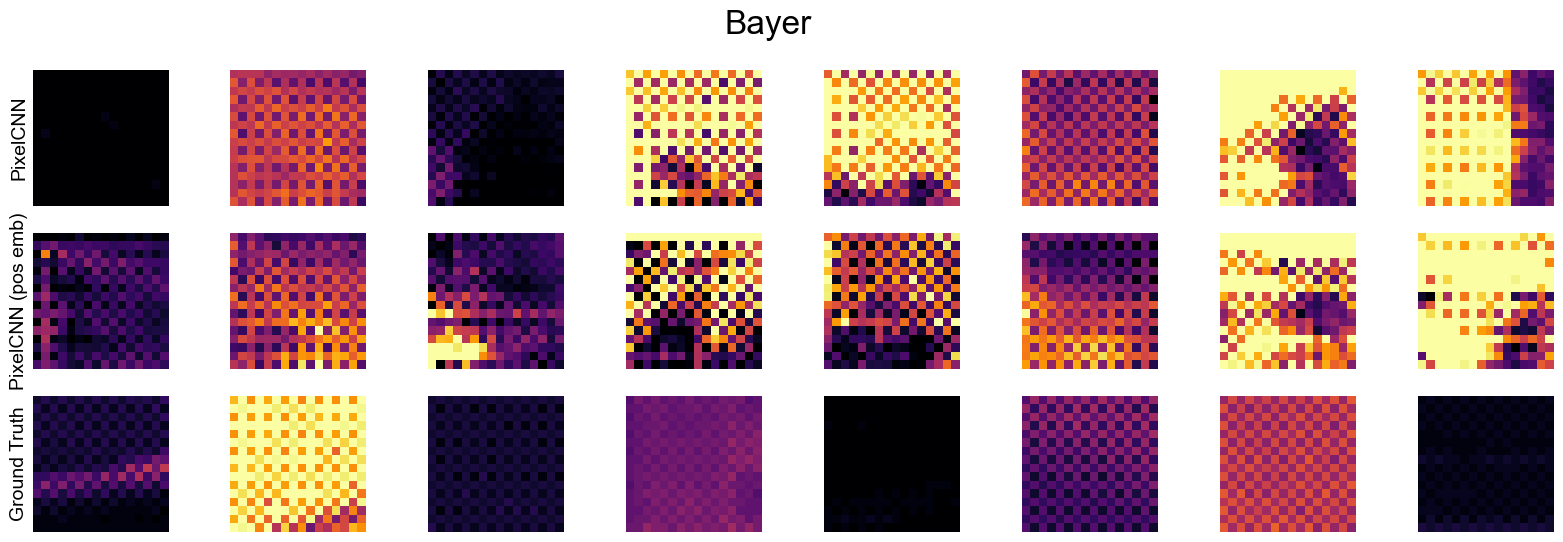

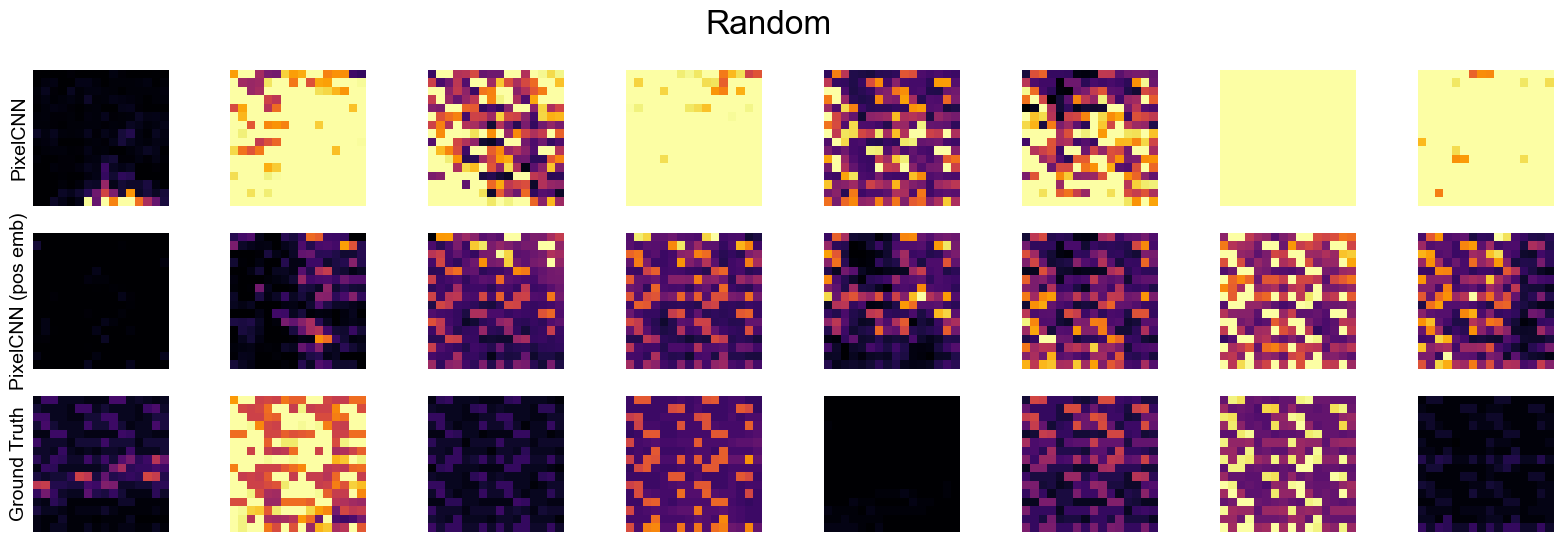

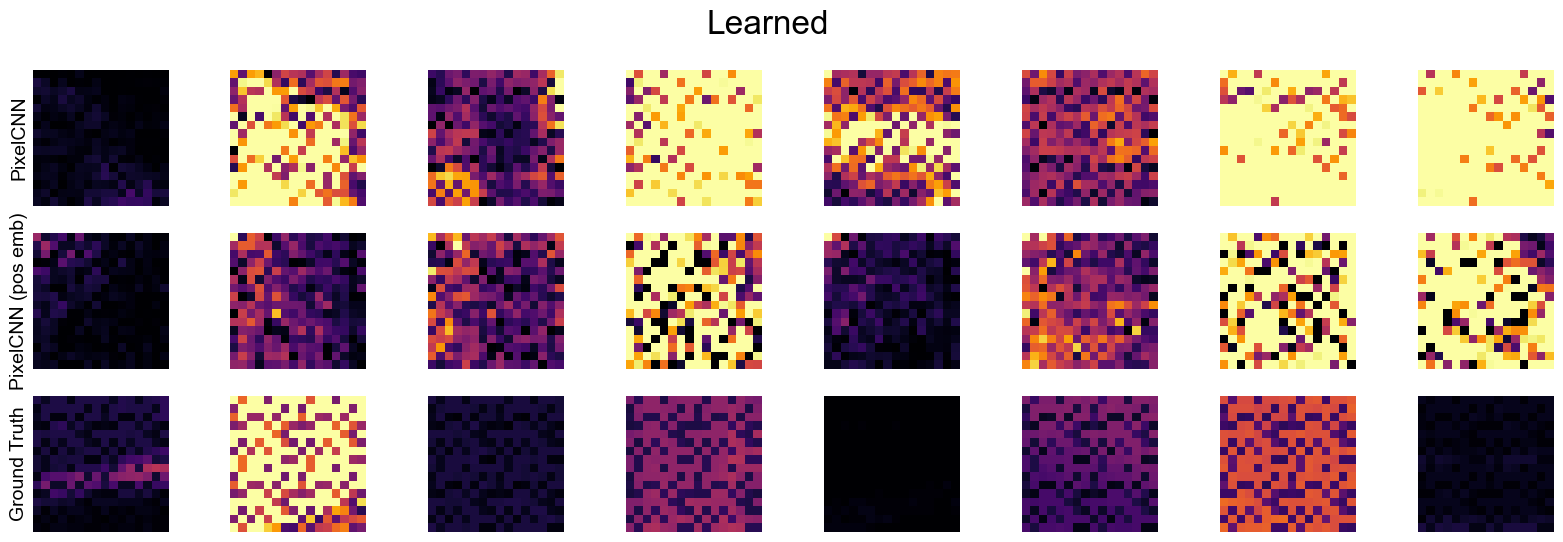

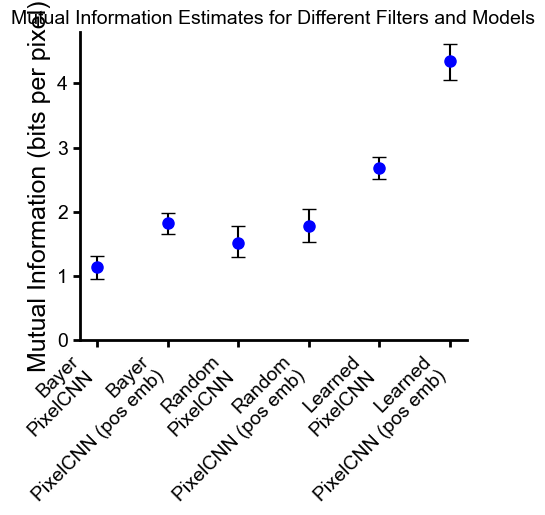

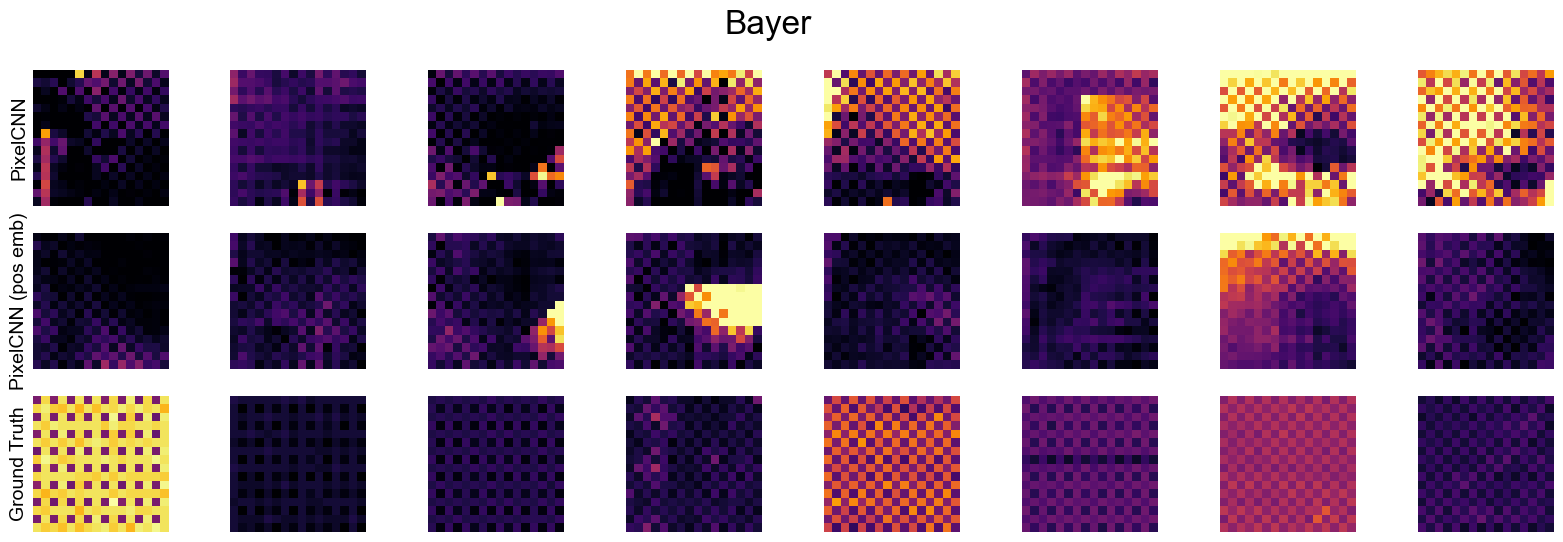

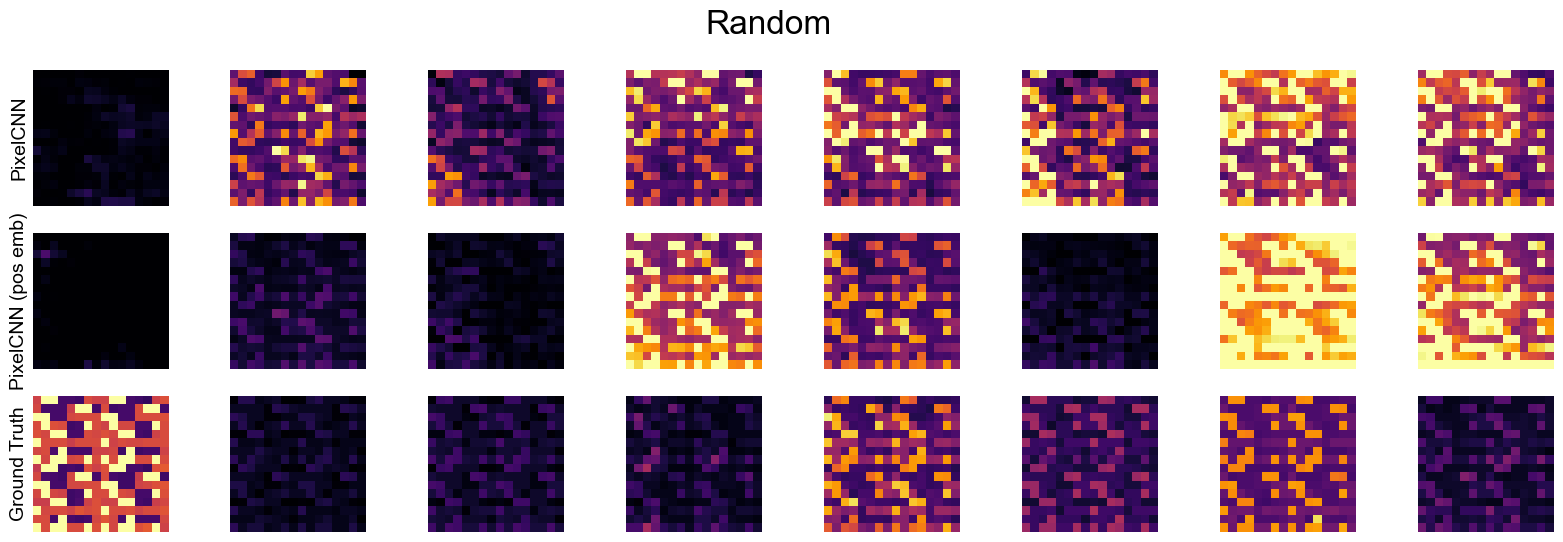

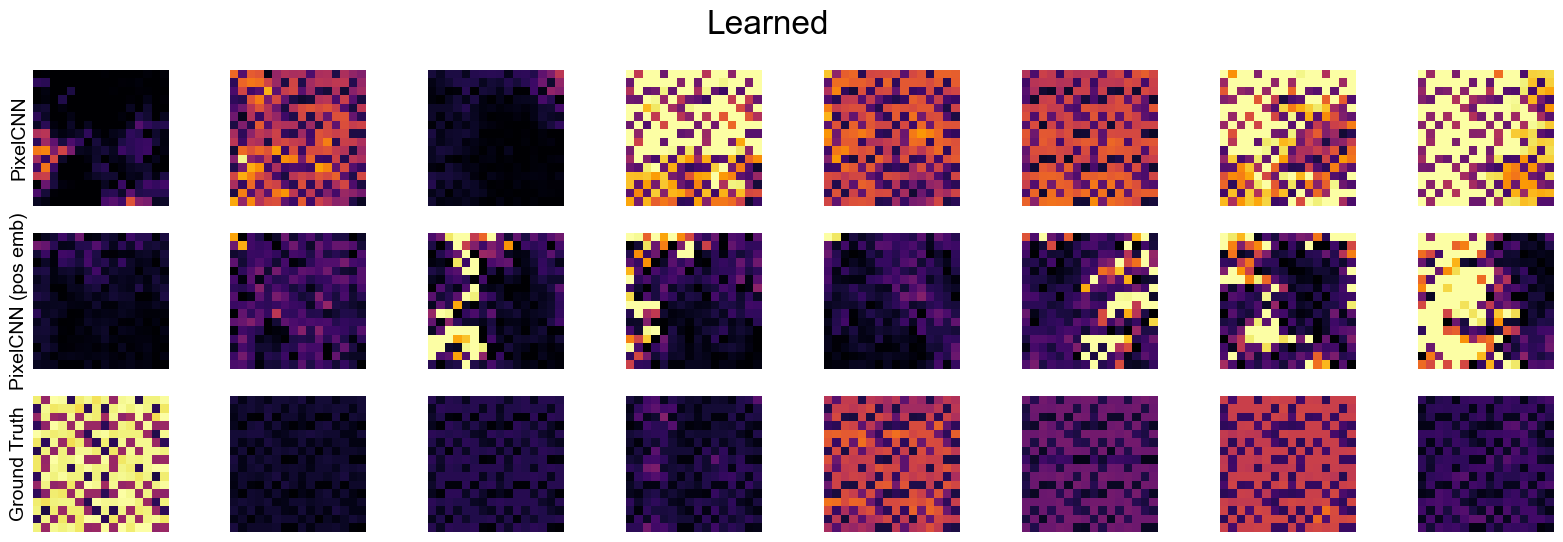

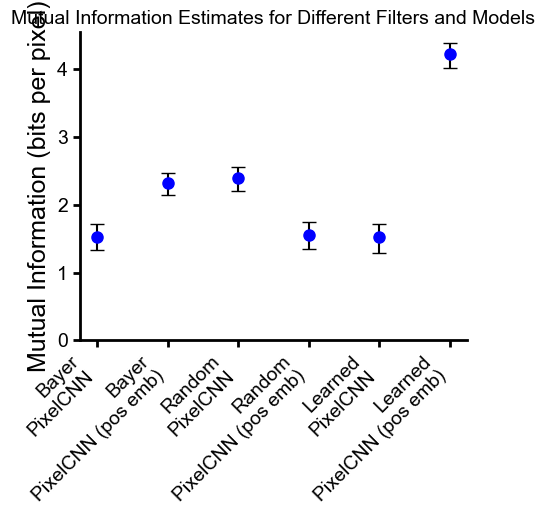

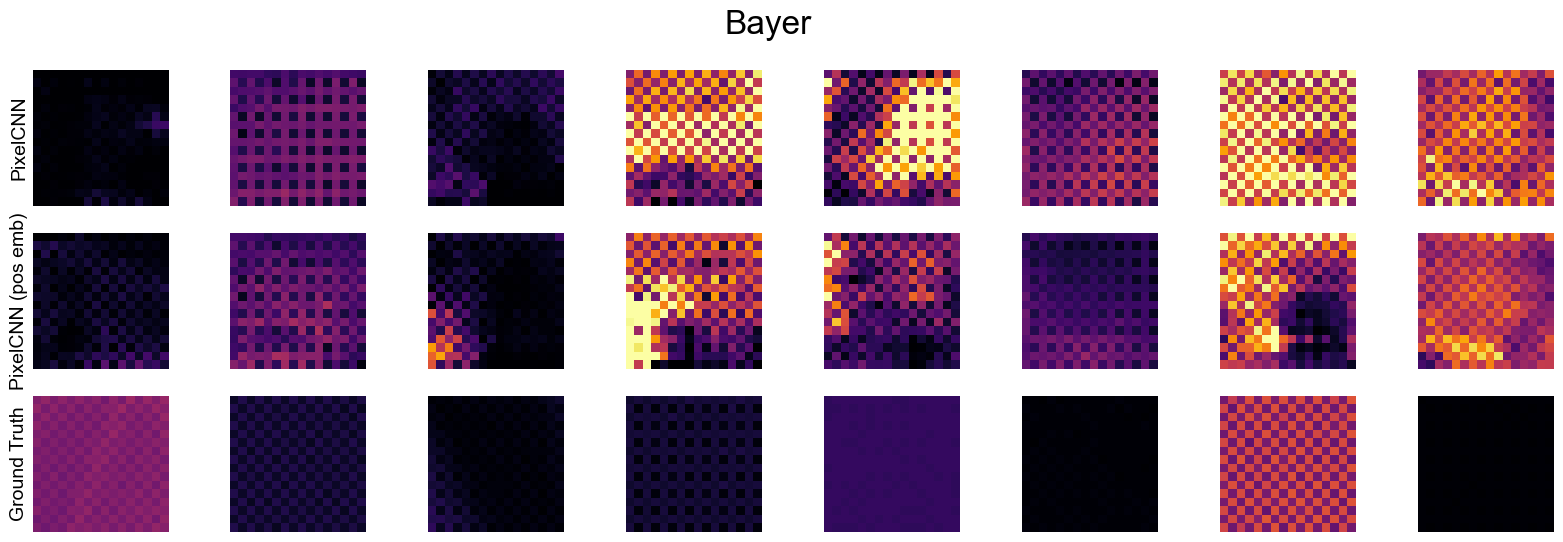

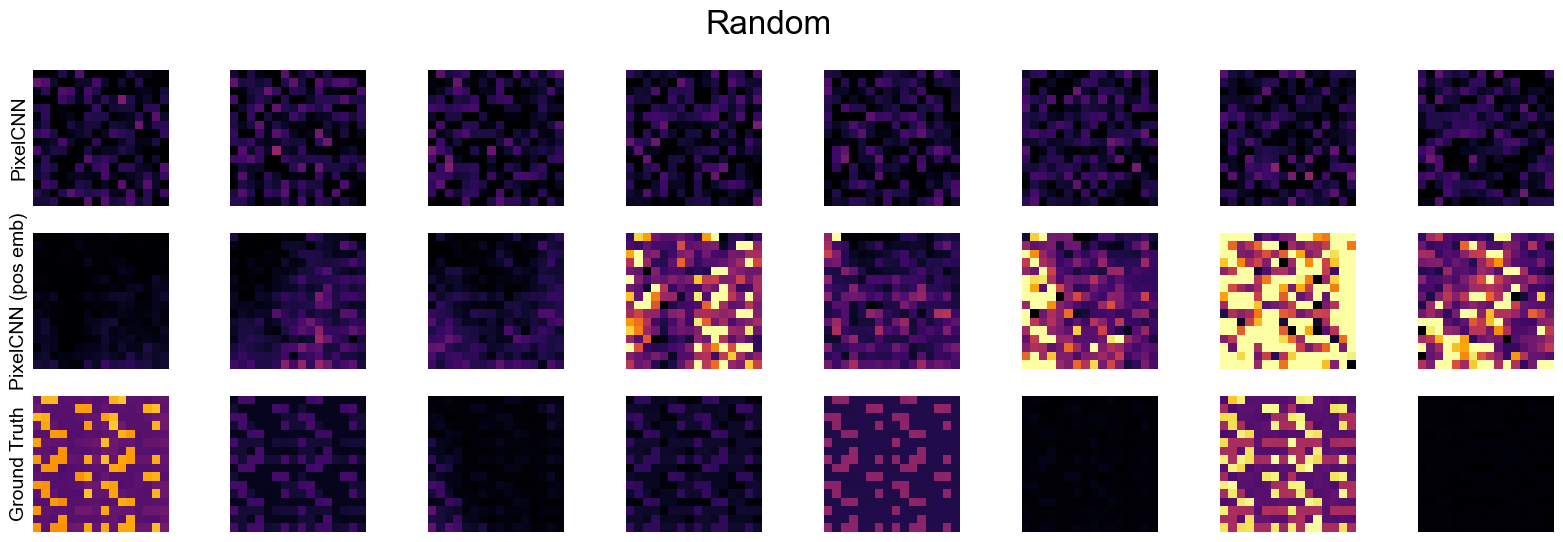

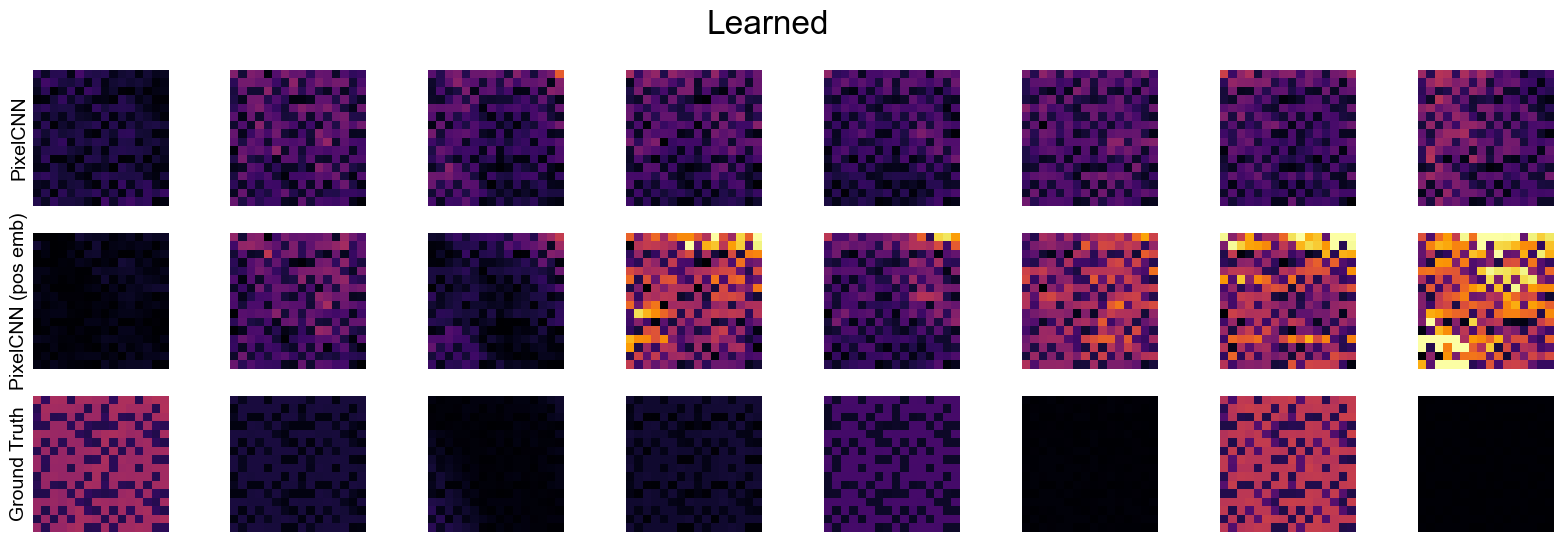

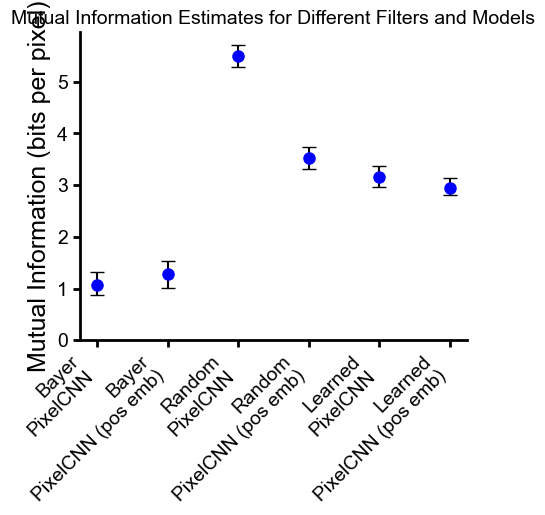

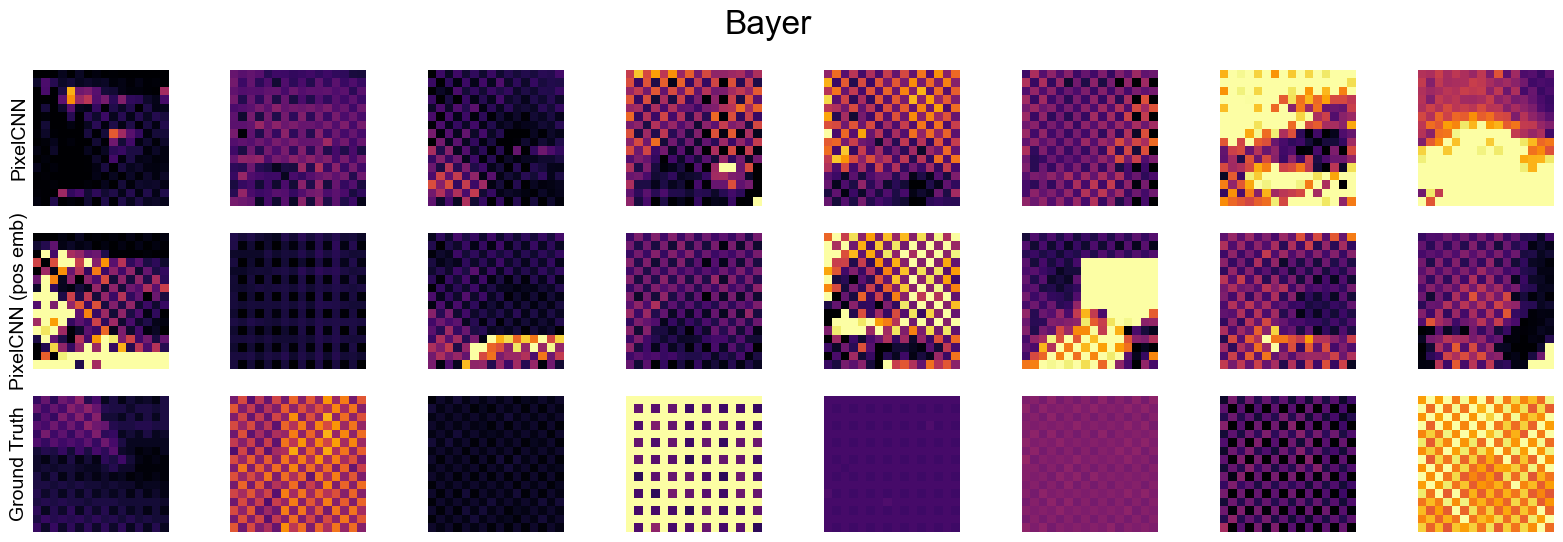

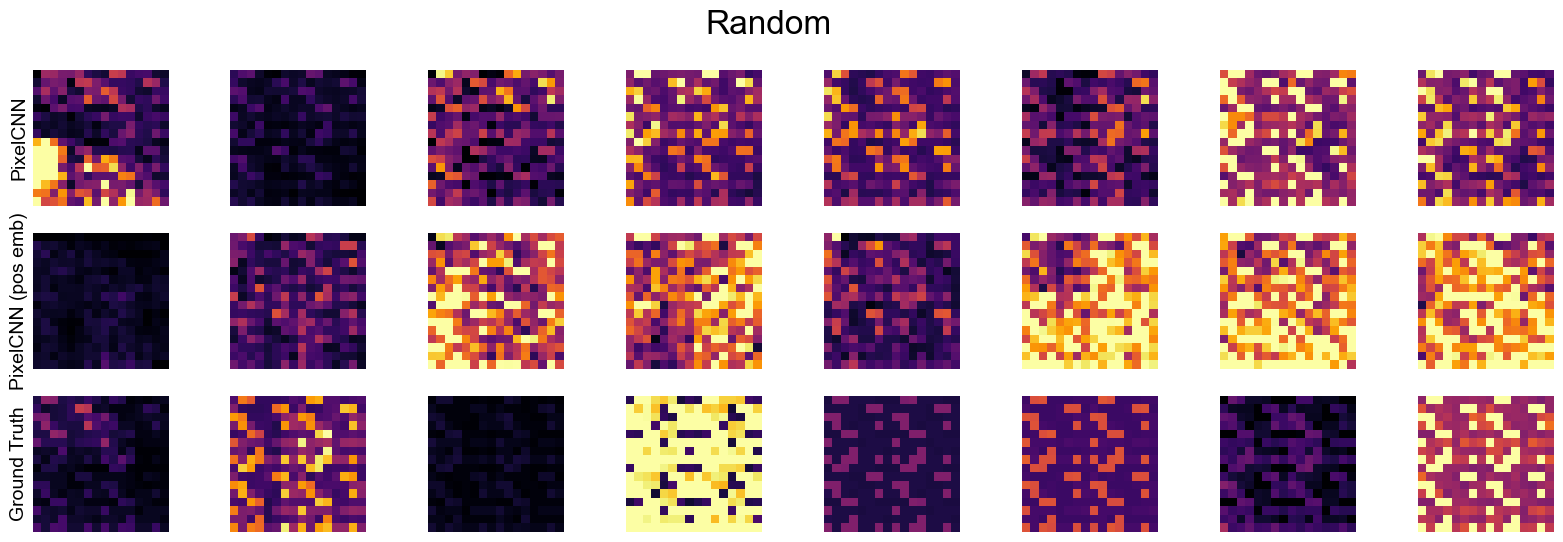

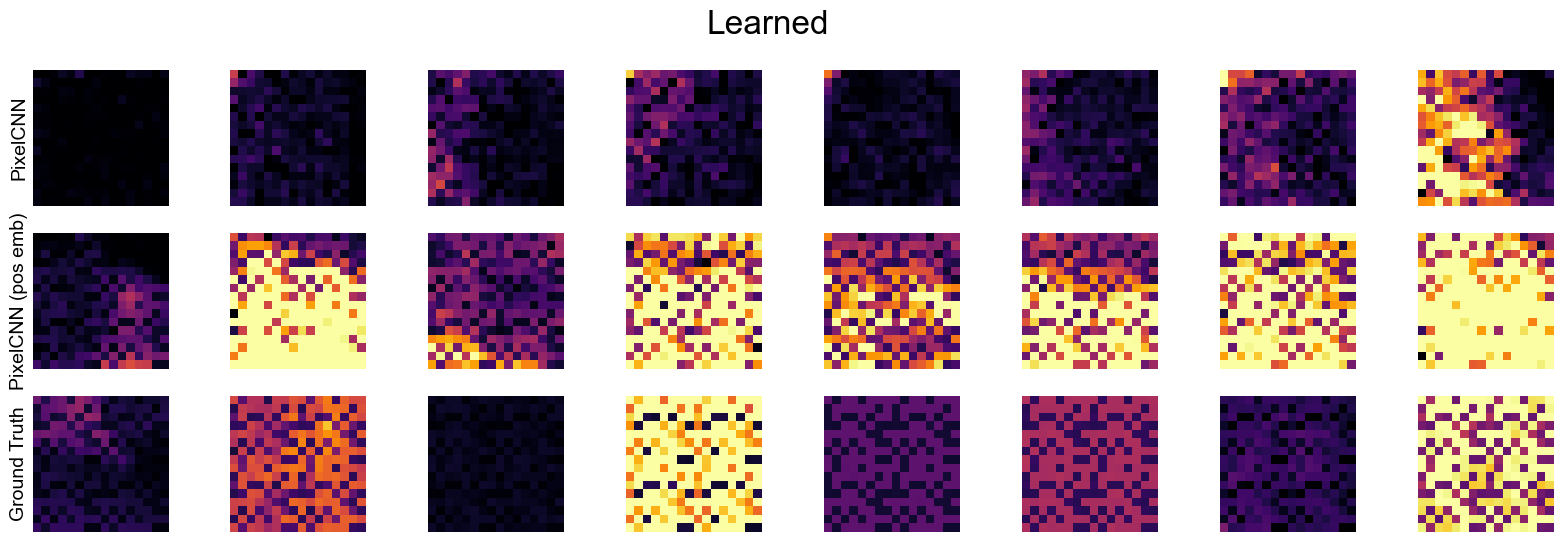

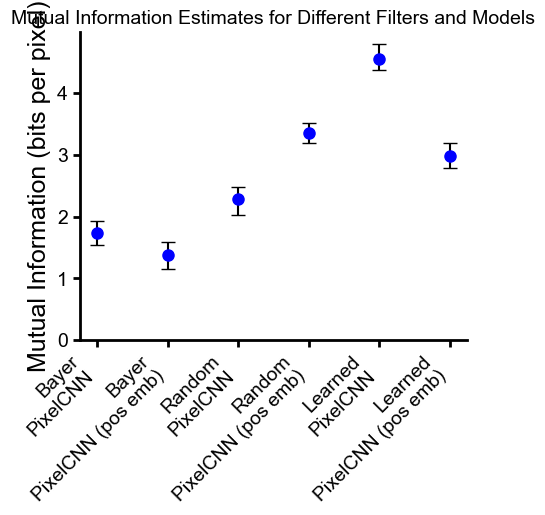

In [20]:
from encoding_information.models import PixelCNN, FullGaussianProcess
from encoding_information import extract_patches
from encoding_information.models import PoissonNoiseModel
from encoding_information import estimate_information
from encoding_information.plot_utils import plot_samples


onp.random.seed(1253)
filters = [
        [[0, 1], [1, 2]],  # Bayer pattern
        onp.random.randint(0, 4, (8, 8)),  # Random pattern
 np.array([[3,1,3,3,0,3,3,3],  # The end-to-end learned filter
                    [0,3,3,3,3,3,0,3],
                    [1,3,2,2,3,2,3,3],
                    [0,2,3,3,1,3,1,2],
                    [3,3,3,3,3,1,0,3],
                    [3,0,3,1,3,3,1,0],
                    [0,3,2,3,1,3,3,3],
                    [3,1,3,3,3,3,2,2]])
]


###### Get data

patch_size = 16
num_patches = 2000
test_set_size = 200
# data_seed = 382873

dataset = ColorFilterArrayDataset('/home/hpinkard_waller/data/four_channel_images.zarr', tile_size=128)

for replicate in range(8):

        info_values = []
        lower_errors = []
        upper_errors = []
        xticklabels = []

        for filter_name, filter in zip(['Bayer', 'Random', 'Learned'], filters):
                measurements = dataset.get_measurements(num_measurements=num_patches + test_set_size, filter_matrix=filter, noise=None, data_seed=replicate)

                patches = extract_patches(measurements[:-test_set_size], patch_size=patch_size, num_patches=num_patches, strategy='cropped', crop_location=(0, 0), verbose=True)
                test_patches = extract_patches(measurements[-test_set_size:], patch_size=patch_size, num_patches=test_set_size, strategy='cropped', crop_location=(0, 0), verbose=True)                          

                #### Fit models
                num_samples = 8

                pixel_cnn = PixelCNN()
                pixel_cnn_val_loss = pixel_cnn.fit(patches, verbose=False, patience=1000, max_epochs=230)

                pixel_cnn_positional_embedding = PixelCNN()
                pixel_cnn_pos_embed_loss = pixel_cnn_positional_embedding.fit(patches, use_positional_embedding=True, verbose=False, patience=1000, max_epochs=230)

                #### generate samples
                pixel_cnn_samples = pixel_cnn.generate_samples(num_samples=num_samples)
                pixel_cnn_positional_embedding_samples = pixel_cnn_positional_embedding.generate_samples(num_samples=num_samples)

                noise_model = PoissonNoiseModel()

                pixel_cnn_info, pixel_cnn_lower_bound, pixel_cnn_upper_bound = estimate_information(pixel_cnn, noise_model, patches, test_patches, confidence_interval=0.9)
                pixel_cnn_positional_embedding_info, pixel_cnn_positional_embedding_lower_bound, pixel_cnn_positional_embedding_upper_bound = estimate_information(
                                pixel_cnn_positional_embedding, noise_model, patches, test_patches, confidence_interval=0.9)

                pixel_cnn_lower_error = np.abs(pixel_cnn_info - pixel_cnn_lower_bound)
                pixel_cnn_upper_error = np.abs(pixel_cnn_upper_bound - pixel_cnn_info)

                pixel_cnn_positional_embedding_lower_error = np.abs(pixel_cnn_positional_embedding_info - pixel_cnn_positional_embedding_lower_bound)
                pixel_cnn_positional_embedding_upper_error = np.abs(pixel_cnn_positional_embedding_upper_bound - pixel_cnn_positional_embedding_info)

                info_values.append(pixel_cnn_info)
                lower_errors.append(pixel_cnn_lower_error)
                upper_errors.append(pixel_cnn_upper_error)

                info_values.append(pixel_cnn_positional_embedding_info)
                lower_errors.append(pixel_cnn_positional_embedding_lower_error)
                upper_errors.append(pixel_cnn_positional_embedding_upper_error)

                xticklabels.append(f'{filter_name}\nPixelCNN')
                xticklabels.append(f'{filter_name}\nPixelCNN (pos emb)')

                # plot the samples
                plot_samples([pixel_cnn_samples, pixel_cnn_positional_embedding_samples], test_patches,
                              model_names=['PixelCNN', 'PixelCNN (pos emb)'], contrast_cutoff=95)
                plt.gcf().suptitle(filter_name)


        # Plot the results
        fig, ax = plt.subplots(figsize=(5, 4))

        x_positions = np.arange(len(info_values))
        error_bars = [lower_errors, upper_errors]

        ax.errorbar(x_positions, info_values, yerr=error_bars, fmt='o', capsize=5, ecolor='black', markersize=8, color='blue')

        ax.set_ylabel('Mutual Information (bits per pixel)')
        ax.set_xticks(x_positions)
        ax.set_xticklabels(xticklabels, rotation=45, ha='right')
        ax.set_ylim([0, None])
        ax.set_title('Mutual Information Estimates for Different Filters and Models')

        clear_spines(ax)
